# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

import pitszi

import macsj0717_libs as libs

# Parameters

In [2]:
# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 25*u.kpc
los_size = 5*u.Mpc

# Analysis parameters
Nsim = 1000
mask_theta = 2*u.arcmin
apply_radial_model = True
RM = 5
clean_ksz = False
ps_mask = False
Xspec = False

# Output directory
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/Pk_constraint_RM'+str(RM)+'_Xspec'+str(Xspec)+'_cleanksz'+str(clean_ksz)+'_psmask'+str(ps_mask)+'_appradmod'+str(apply_radial_model)+'_maskangle'+str(mask_theta.to_value('arcmin'))
print(outdir)
if not os.path.exists(outdir): os.makedirs(outdir)

/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0


# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

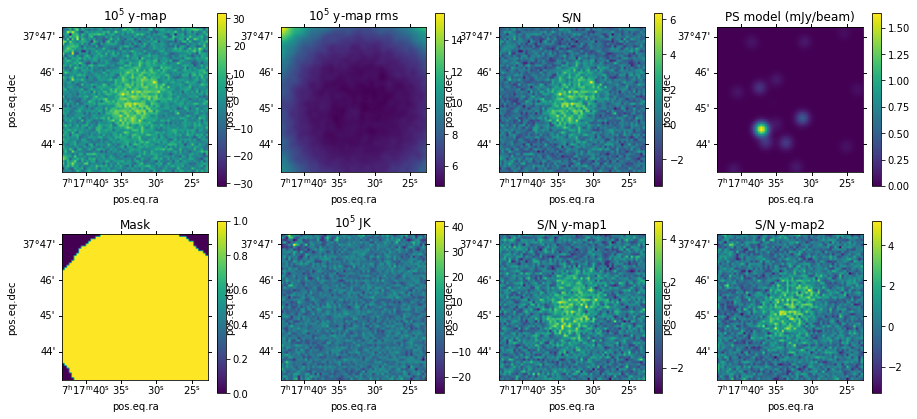

In [4]:
#===== Get the data
if ps_mask: 
    ps_mask_lim = 0.1
else:
    ps_mask_lim = 0.1*100

cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True,
                                                                                                     clean_ksz=clean_ksz)

# Defines model, data

In [5]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)
cl_data1 = libs.def_data(cl_img1, cl_head, cl_noise*2**0.5, cl_mask, beam_FWHM, TF, outdir, Nsim)
cl_data2 = libs.def_data(cl_img2, cl_head, cl_noise*2**0.5, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [6]:
#========== Cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

cl_model.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 61 , 61 , 201
   Pixel size :      26.3     kpc ;     4.0      arcsec
   Fov size :  [   1605.3   ,   1605.3   ] kpc ; [   4.067    ,   4.067    ] arcmin
   L.o.S. resolution :         25.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (109.3875, 37.75416667)>
   k min/max projected :       0.004098  /  0.122951   1/arcsec
   k min/max projected :       0.000623  /  0.018688   1/kpc
   k min/max L.o.S. (eq.) :    0.001309  /  0.130931   1/arcsec
   k min/max L.o.S. :          0.000199  /  0.019900   1/kpc
   k max Nyquist :             0.122951   1/arcsec
   k max Nyquist :             0.018688   1/kpc


# Inference radial

In [7]:
#========== Radial inference
cl_Rinfer = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir='/Users/adam/Desktop/')
fitpar_prof = libs.def_fitparprof(RM)
plist, popt, pcov = cl_Rinfer.run_curvefit_profile(fitpar_prof, show_fit_result=False, set_bestfit=True)

# Inference fluctuations

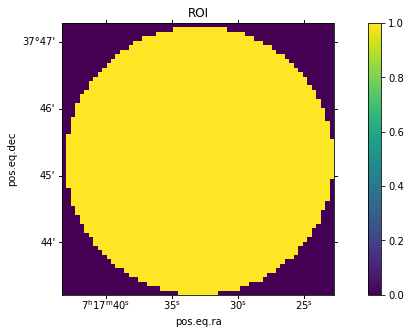

In [8]:
roi = libs.def_roi(cl_head, cl_Rinfer.model, mask_theta=mask_theta, show=True)

In [9]:
extname = '_'+str(Nsim)+'_'+str(cl_head['NAXIS1'])+'_'+str(cl_head['NAXIS2'])+'_'+str(round(cl_head['CDELT2']*3600))
cib_path = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/CIB_simulations'+extname+'.npy'
if os.path.exists(cib_path):
    cib_mc = np.load(cib_path)
else:
    cib_mc = libs.simu_cib(cl_head['CRVAL1'], cl_head['CRVAL2'], cl_head, beam_FWHM, TF,
                           Nsim=Nsim, Scut_high=0.4, Scut_low=0.004)/np.mean(y2jy)
    np.save(cib_path, cib_mc)

In [ ]:
#========== Pk inference
# Define inference
if Xspec: 
    cl_Finfer = pitszi.InferenceFluctuation(cl_data1, cl_Rinfer.model, data2=cl_data2, 
                                            nuisance_bkg_mc1=cib_mc, nuisance_bkg_mc2=cib_mc,
                                            method_use_covmat=True, silent=False, output_dir=outdir)
else:
    cl_Finfer = pitszi.InferenceFluctuation(cl_data, cl_Rinfer.model, 
                                            nuisance_bkg_mc1=cib_mc,
                                            method_use_covmat=True, silent=False, output_dir=outdir)

# Define binning
cl_Finfer.kbin_min   = 1/(4*u.arcmin)
cl_Finfer.kbin_max   = 1/(10*u.arcsec)
cl_Finfer.kbin_Nbin  = 30
cl_Finfer.kbin_scale = 'lin'

# Weight definition
cl_Finfer.set_method_w8(roi_mask=roi,
                        apply_data_mask=True,
                        apply_radial_model=True, 
                        conv_radial_model_beam=True, 
                        conv_radial_model_TF=False, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=20*u.arcsec)
    
# Setup
cl_Finfer.pk_setup(Nmc=Nsim)

# Show the weight
plt.imshow(cl_Finfer.method_w8, origin='lower')
plt.colorbar()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [  4.  12.  16.  20.  12.  32.  36.  32.  28.  44.  52.  48.  44.  52.
  68.  72.  64.  76.  76.  76.  80.  92.  76. 108.  88. 120. 100. 108.
 116. 120.]
      - Minimal count in k bins: 4.0
    * Setup Pk data, ref model and noise


In [ ]:
if Xspec:
    fitpar_pk3d = {
        'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
        #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
        'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[50, 5000]}, #, 'prior':[600, 300],      
        'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
    }
else:
    fitpar_pk3d = {
        'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
        #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
        'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[50, 5000]}, #, 'prior':[600, 300],      
        'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 10]},
        'Abkg':{'guess':[1, 0.2],'unit': None,'limit':[0, 5]},
    }

In [ ]:
# First fit to obtain the guess model
plist, popt, pcov = cl_Finfer.run_curvefit_fluctuation(fitpar_pk3d,
                                                       show_fit_result=True,
                                                       include_model_error=False,
                                                       set_bestfit=True)
# Second fit including model uncertainties
plist, popt, pcov = cl_Finfer.run_curvefit_fluctuation(fitpar_pk3d,
                                                       show_fit_result=True,
                                                       include_model_error=True,
                                                       set_bestfit=True)
# Third fit to check the stability
plist, popt, pcov = cl_Finfer.run_curvefit_fluctuation(fitpar_pk3d,
                                                       show_fit_result=True,
                                                       include_model_error=True,
                                                       set_bestfit=True)

np.save(outdir+'/CurveFit_Fluctuation_results.npy', (plist, popt, pcov.flatten()), allow_pickle=True)

In [ ]:
cl_Finfer.mcmc_nwalkers = 20
cl_Finfer.mcmc_nsteps   = 2100
cl_Finfer.mcmc_burnin   = 100
cl_Finfer.mcmc_reset    = True
cl_Finfer.mcmc_run      = True

plist, sampler = cl_Finfer.run_mcmc_fluctuation(fitpar_pk3d, 
                                                kind='projection', 
                                                show_fit_result=True,
                                                include_model_error=True,
                                                set_bestfit=True)

# Compute the 2D likelihood comparison

In [ ]:
def fake_chains_curvefit(parinfo, popt, pcov, Nsample=10000):
    par_chains = np.zeros((Nsample, len(popt)))
    isamp = 0
    while isamp < Nsample:
        param = np.random.multivariate_normal(popt, pcov)
        cond = np.isfinite(cl_Finfer.prior_fluctuation(param, parinfo))
        if cond:
            par_chains[isamp,:] = param
            isamp += 1
    return par_chains[np.newaxis]

In [ ]:
base = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'
pars1 = np.load(base+'Pk_constraint_RM1_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars2 = np.load(base+'Pk_constraint_RM2_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars3 = np.load(base+'Pk_constraint_RM3_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars4 = np.load(base+'Pk_constraint_RM4_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars5 = np.load(base+'Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)

plist1, popt1, pcov1 = pars1[0], pars1[1], pars1[2].reshape(4,4)
plist2, popt2, pcov2 = pars2[0], pars2[1], pars2[2].reshape(4,4)
plist3, popt3, pcov3 = pars3[0], pars3[1], pars3[2].reshape(4,4)
plist4, popt4, pcov4 = pars4[0], pars4[1], pars4[2].reshape(4,4)
plist5, popt5, pcov5 = pars5[0], pars5[1], pars5[2].reshape(4,4)

In [ ]:
chains1 = fake_chains_curvefit(fitpar_pk3d, popt1, pcov1)
chains2 = fake_chains_curvefit(fitpar_pk3d, popt2, pcov2)
chains3 = fake_chains_curvefit(fitpar_pk3d, popt3, pcov3)
chains4 = fake_chains_curvefit(fitpar_pk3d, popt4, pcov4)
chains5 = fake_chains_curvefit(fitpar_pk3d, popt5, pcov5)

In [ ]:
df1 = pd.DataFrame(np.array([chains1[0][:,0], chains1[0][:,1], chains1[0][:,2], chains1[0][:,3]]).T, columns=[r'$\sigma_{P}$', r'$L_{inj}$', r'$A_{noise}$', r'$A_{CIB}$'])
df2 = pd.DataFrame(np.array([chains2[0][:,0], chains2[0][:,1], chains2[0][:,2], chains2[0][:,3]]).T, columns=[r'$\sigma_{P}$', r'$L_{inj}$', r'$A_{noise}$', r'$A_{CIB}$'])
df3 = pd.DataFrame(np.array([chains3[0][:,0], chains3[0][:,1], chains3[0][:,2], chains3[0][:,3]]).T, columns=[r'$\sigma_{P}$', r'$L_{inj}$', r'$A_{noise}$', r'$A_{CIB}$'])
df4 = pd.DataFrame(np.array([chains4[0][:,0], chains4[0][:,1], chains4[0][:,2], chains4[0][:,3]]).T, columns=[r'$\sigma_{P}$', r'$L_{inj}$', r'$A_{noise}$', r'$A_{CIB}$'])
df5 = pd.DataFrame(np.array([chains5[0][:,0], chains5[0][:,1], chains5[0][:,2], chains5[0][:,3]]).T, columns=[r'$\sigma_{P}$', r'$L_{inj}$', r'$A_{noise}$', r'$A_{CIB}$'])

In [ ]:
pitszi.utils_plot.seaborn_corner([df2, df3, df4], output_fig=base+'PDF_RM_comparison.pdf',
                                 labels=['$RM_2$', '$RM_3$', '$RM_4$'],
                                 smoothing1d=1,smoothing2d=1,
                                 gridsize=20, linewidth=0.75, alpha=(0.3, 0.3, 1.0), n_levels=None,
                                 zoom=1.0/10, add_grid=False, limits=[(0.4,0.9),(400,1200),(0.85,1.15),(0,5)],
                                 figsize=(10,10), fontsize=12,
                                 cols = [('orange',None,'orange','Oranges'),
                                         #('green',None,'green','Greens'), 
                                         #('magenta',None,'magenta','RdPu'),
                                         ('purple',None,'purple','Purples'), 
                                         ('cyan',None,'cyan','ocean_r'),
                                         #('cyan',None,'cyan','cool'),
                                         ('k',None,'k','Greys')])

In [ ]:
#========== Get the best-fit
cl_model.model_pressure_fluctuation['Norm'] = popt1[0]
cl_model.model_pressure_fluctuation['Linj'] = popt1[1]*u.kpc
k3d, best_pk3d_1 = cl_model.get_pressure_fluctuation_spectrum(np.logspace(-4,-1,100)*u.kpc**-1)

cl_model.model_pressure_fluctuation['Norm'] = popt2[0]
cl_model.model_pressure_fluctuation['Linj'] = popt2[1]*u.kpc
k3d, best_pk3d_2 = cl_model.get_pressure_fluctuation_spectrum(np.logspace(-4,-1,100)*u.kpc**-1)

cl_model.model_pressure_fluctuation['Norm'] = popt3[0]
cl_model.model_pressure_fluctuation['Linj'] = popt3[1]*u.kpc
k3d, best_pk3d_3 = cl_model.get_pressure_fluctuation_spectrum(np.logspace(-4,-1,100)*u.kpc**-1)

cl_model.model_pressure_fluctuation['Norm'] = popt4[0]
cl_model.model_pressure_fluctuation['Linj'] = popt4[1]*u.kpc
k3d, best_pk3d_4 = cl_model.get_pressure_fluctuation_spectrum(np.logspace(-4,-1,100)*u.kpc**-1)

cl_model.model_pressure_fluctuation['Norm'] = popt5[0]
cl_model.model_pressure_fluctuation['Linj'] = popt5[1]*u.kpc
k3d, best_pk3d_5 = cl_model.get_pressure_fluctuation_spectrum(np.logspace(-4,-1,100)*u.kpc**-1)

#========== Get the MC
MC_pk3d_1 = np.zeros((1000, len(k3d)))
MC_pk3d_2 = np.zeros((1000, len(k3d)))
MC_pk3d_3 = np.zeros((1000, len(k3d)))
MC_pk3d_4 = np.zeros((1000, len(k3d)))
MC_pk3d_5 = np.zeros((1000, len(k3d)))
for imc in range(1000):
    cl_model.model_pressure_fluctuation['Norm'] = chains1[0][imc,0]
    cl_model.model_pressure_fluctuation['Linj'] = chains1[0][imc,1]*u.kpc
    MC_pk3d_1[imc,:] = cl_model.get_pressure_fluctuation_spectrum(k3d)[1].to_value('kpc3')
    
    cl_model.model_pressure_fluctuation['Norm'] = chains2[0][imc,0]
    cl_model.model_pressure_fluctuation['Linj'] = chains2[0][imc,1]*u.kpc
    MC_pk3d_2[imc,:] = cl_model.get_pressure_fluctuation_spectrum(k3d)[1].to_value('kpc3')
    
    cl_model.model_pressure_fluctuation['Norm'] = chains3[0][imc,0]
    cl_model.model_pressure_fluctuation['Linj'] = chains3[0][imc,1]*u.kpc
    MC_pk3d_3[imc,:] = cl_model.get_pressure_fluctuation_spectrum(k3d)[1].to_value('kpc3')

    cl_model.model_pressure_fluctuation['Norm'] = chains4[0][imc,0]
    cl_model.model_pressure_fluctuation['Linj'] = chains4[0][imc,1]*u.kpc
    MC_pk3d_4[imc,:] = cl_model.get_pressure_fluctuation_spectrum(k3d)[1].to_value('kpc3')

    cl_model.model_pressure_fluctuation['Norm'] = chains5[0][imc,0]
    cl_model.model_pressure_fluctuation['Linj'] = chains5[0][imc,1]*u.kpc
    MC_pk3d_5[imc,:] = cl_model.get_pressure_fluctuation_spectrum(k3d)[1].to_value('kpc3')
    
pk3d_percA_1 = np.percentile(MC_pk3d_1,(100-(100-68)/2.0, 50, (100-68)/2.0), axis=0)
pk3d_percB_1 = np.percentile(MC_pk3d_1,(100-(100-95)/2.0, 50, (100-95)/2.0), axis=0)
pk3d_percA_2 = np.percentile(MC_pk3d_2,(100-(100-68)/2.0, 50, (100-68)/2.0), axis=0)
pk3d_percB_2 = np.percentile(MC_pk3d_2,(100-(100-95)/2.0, 50, (100-95)/2.0), axis=0)
pk3d_percA_3 = np.percentile(MC_pk3d_3,(100-(100-68)/2.0, 50, (100-68)/2.0), axis=0)
pk3d_percB_3 = np.percentile(MC_pk3d_3,(100-(100-95)/2.0, 50, (100-95)/2.0), axis=0)
pk3d_percA_4 = np.percentile(MC_pk3d_4,(100-(100-68)/2.0, 50, (100-68)/2.0), axis=0)
pk3d_percB_4 = np.percentile(MC_pk3d_4,(100-(100-95)/2.0, 50, (100-95)/2.0), axis=0)
pk3d_percA_5 = np.percentile(MC_pk3d_5,(100-(100-68)/2.0, 50, (100-68)/2.0), axis=0)
pk3d_percB_5 = np.percentile(MC_pk3d_5,(100-(100-95)/2.0, 50, (100-95)/2.0), axis=0)

In [ ]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(0, figsize=(7, 5))

#plt.loglog(k3d, np.sqrt(4*np.pi*k3d**3*best_pk3d_1), color='orange', label=r'$RM_1$')
#plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_1[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_1[2]).value, color='orange', alpha=0.2)
#plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_1[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_1[2]).value, color='orange', alpha=0.2)

plt.loglog(k3d, np.sqrt(4*np.pi*k3d**3*best_pk3d_2), color='orange', label=r'$RM_2$')
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_2[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_2[2]).value, color='orange', alpha=0.2)
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_2[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_2[2]).value, color='orange', alpha=0.2)

plt.loglog(k3d, np.sqrt(4*np.pi*k3d**3*best_pk3d_3), color='magenta', label=r'$RM_3$')
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_3[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_3[2]).value, color='magenta', alpha=0.2)
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_3[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_3[2]).value, color='magenta', alpha=0.2)

plt.loglog(k3d, np.sqrt(4*np.pi*k3d**3*best_pk3d_4), color='blue', label=r'$RM_4$')
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_4[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_4[2]).value, color='blue', alpha=0.2)
plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_4[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_4[2]).value, color='blue', alpha=0.2)

#plt.loglog(k3d, np.sqrt(4*np.pi*k3d**3*best_pk3d_5), color='blue', label=r'$RM_5$')
#plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_5[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percA_5[2]).value, color='blue', alpha=0.2)
#plt.fill_between(k3d.value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_5[0]).value, np.sqrt(4*np.pi*k3d**3*pk3d_percB_5[2]).value, color='blue', alpha=0.2)

plt.ylim(1e-2,1e0)
plt.xlim(1e-4,1e-1)
plt.legend()
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.savefig(base+'Pk3d_RM_comparison.pdf')

In [ ]:
cl_model.D_ang.to_value('km')